Learning the basics of neural nets by implementing basic algos from scratch. This notebook is used to test and demo matrixgrad.py. It is is based on Andrej Karpathy's https://github.com/karpathy/micrograd applied to 2d numpy arrays; so kind of a blend of his micrograd and backprop ninja online classes in https://karpathy.ai/zero-to-hero.html

First, let's test and look at the autograd layer in matrixgrad.py. The code below creates a graph function to visualize a DAG of Matrix classes and uses that to visualize the graph created by performing operations on Matrices

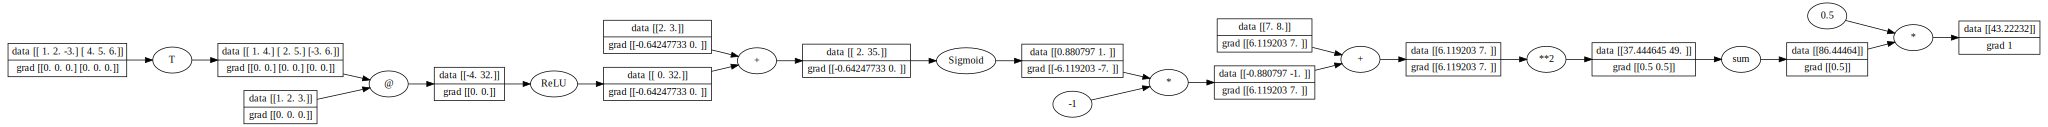

MatrixGrad and PyTorch autograds match for sigmoid(relu(x @ w) + b)


In [1]:
from matrixgrad import Matrix, sigmoid, relu
import numpy as np

from graphviz import Digraph
def graph(self, details=True):
    def trace(root):
        nodes, edges = set(), set()
        def build(v):
            if v not in nodes:
                nodes.add(v)
                if isinstance(v, Matrix):
                    for child in v._prev:
                        edges.add((child, v))
                        build (child)
        build(root)
        return nodes, edges
    
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})
    nodes, edges = trace(self)
    for n in nodes:
        uid = str(id(n))
        if not isinstance(n, Matrix):
            dot.node(name=uid, label = str(n), shape="oval")
        else:
            if details:
                dot.node(name=uid, label = f"data {n.data} | grad {n.grad}", shape="record")
            else:
                dot.node(name=uid, label = f"data {n.data.shape}", shape="record")
            if n._op:
                dot.node(name = uid + n._op, label = n._op)
                dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


# Do the auto-grad thing with the Matrix class
w = Matrix([[1,2,-3],[4,5,6]]).transpose()
b = Matrix([2,3])
x = Matrix([1,2,3])
y = Matrix([7, 8])
y_hat = sigmoid(relu(x @ w) + b)
loss = ((y-y_hat)**2).sum()/y.shape[1]
loss.backward()
display (graph(loss))

# Now try the same thing with PyTorch
import torch
t_x = torch.tensor(x.data, dtype=torch.float32)
t_w = torch.tensor(w.data, dtype=torch.float32, requires_grad=True)
t_b = torch.tensor(b.data, dtype=torch.float32, requires_grad=True)
t_y_hat = torch.sigmoid(torch.relu(t_x @ t_w) + t_b)
t_loss = torch.nn.MSELoss()(torch.as_tensor(y.data), t_y_hat)
t_loss.backward()

# Make sure they are the same
assert np.allclose(y_hat.data, t_y_hat.data.numpy()), f"Matrix y_hat {y_hat.data} != torch y_hat {t_y_hat.data}"
assert np.allclose(w.grad, t_w.grad.data.numpy()), f"Matrix grad {w.grad} != torch grad {t_w.grad}"
assert np.allclose(b.grad, t_b.grad.data.numpy()), f"Matrix grad {b.grad} != torch grad {t_b.grad}"

print ("MatrixGrad and PyTorch autograds match for sigmoid(relu(x @ w) + b)")


Next, let's look at how Modules (build on top of Values) can be built run.
We'll visualize the models and gradiants with digraph.
We'll compare the forward and backward pass values with those generated by PyTorch to validate the Matrix code.

MatrixGrad and PyTorch forward and backward pass match for mse loss of Matix operations
Model: Sequential([Layer(inputs=2, outputs=4), ReLU, Layer(inputs=4, outputs=3)])
MatrixGrad and PyTorch forward and backward pass match for mse loss on a sequential model


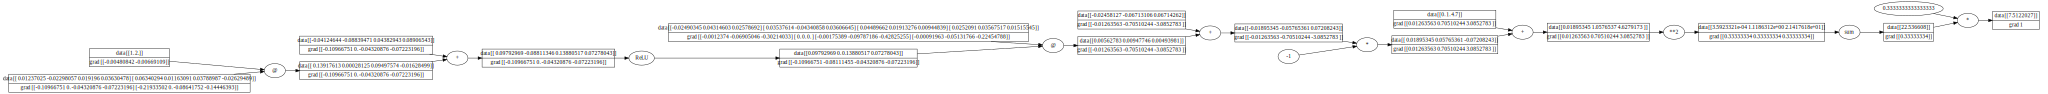

In [2]:
# Simple 3-layer model, internally using Value objects as weights for the linear layers
from matrixgrad import Linear, ReLU, Sequential, mse_loss
import numpy as np

""" Test the classes defined in this file """
l = Linear(2, 3)
x = np.array([[1.0, 2.0]])
y = np.array([[0.0, 1.0, 4.7]])
yhat = l(x)
yhat_relu = relu(yhat)
loss = mse_loss([y], [yhat_relu])
loss.backward()

import torch
t_l = torch.nn.Linear(2, 3)
t_l.weight.data = torch.tensor(l.w.data.T)
t_l.bias.data = torch.tensor(l.b.data)
t_x = torch.tensor(x, dtype=torch.float32)
t_y = torch.tensor(y, dtype=torch.float32)
t_yhat = t_l(t_x)
t_yhat_relu = torch.nn.ReLU()(t_yhat)
t_loss = torch.nn.MSELoss()(t_y, t_yhat_relu)
t_loss.backward()

assert np.allclose(yhat.data, t_yhat.data), "Linear layer output doesn't match PyTorch"
assert np.allclose(yhat_relu.data, t_yhat_relu.data), "ReLU output doesn't match PyTorch"
assert np.allclose(loss.data, t_loss.data), "MSE loss doesn't match PyTorch"
assert np.allclose(l.w.grad, t_l.weight.grad.T), "Linear layer weight gradient doesn't match PyTorch"
assert np.allclose(l.b.grad, t_l.bias.grad), "Linear layer bias gradient doesn't match PyTorch"

print ("MatrixGrad and PyTorch forward and backward pass match for mse loss of Matix operations")

# Now lets try the same thing with a Sequential model
model = Sequential([Linear(2, 4), ReLU(), Linear(4, 3)])
yhat = model(x)
loss = mse_loss([y], [yhat])
loss.backward()
print (f"Model: {model}")

t_model = torch.nn.Sequential(torch.nn.Linear(2, 4), torch.nn.ReLU(), torch.nn.Linear(4, 2))
t_model[0].weight.data = torch.tensor(model.layers[0].w.data.T)
t_model[0].bias.data = torch.tensor(model.layers[0].b.data)
t_model[2].weight.data = torch.tensor(model.layers[2].w.data.T)
t_model[2].bias.data = torch.tensor(model.layers[2].b.data)
t_yhat = t_model(t_x)
t_loss = torch.nn.MSELoss()(t_y, t_yhat)
t_loss.backward()

assert np.allclose(yhat.data, t_yhat.data), "Sequential model output doesn't match PyTorch"
assert np.allclose(loss.data, t_loss.data), "MSE loss doesn't match PyTorch"
assert np.allclose(model.layers[0].w.grad, t_model[0].weight.grad.T), "Linear layer weight gradient doesn't match PyTorch"
assert np.allclose(model.layers[0].b.grad, t_model[0].bias.grad), "Linear layer bias gradient doesn't match PyTorch"
assert np.allclose(model.layers[2].w.grad, t_model[2].weight.grad.T), "Linear layer weight gradient doesn't match PyTorch"
assert np.allclose(model.layers[2].b.grad, t_model[2].bias.grad), "Linear layer bias gradient doesn't match PyTorch"

print ("MatrixGrad and PyTorch forward and backward pass match for mse loss on a sequential model")
display(graph(loss))


Next, let's try training a simple regression model using the layers that sit on top of Matrix/autograd

In [3]:
from matrixgrad import Matrix, Sequential, Linear, ReLU, mse_loss, SGD, fit
import numpy as np

np.random.seed(12)  # 12th man - go Seahawks!

""" Train a model to learn the function f(x1,x2) = x1+x2+1 with SGD and verify the fit """

# Create the model
model = Sequential([Linear(2, 3), ReLU(), Linear(3, 1)])
opt = SGD(model.parameters(), lr=.5, lr_decay=.007)
loss_fn = mse_loss

# Train the model
print (f"Training model {model} to learn 2*x1+x2+1")
x_train = [Matrix([[np.random.uniform(-1, 1), np.random.uniform(-1, 1)]]) for _ in range(128)]
y_train = [2*m.data[0,0] + m.data[0,1] + 1 for m in x_train]
fit (model, x_train, y_train, loss_fn=loss_fn, optimizer=opt, epochs=50, batch_size=32, verbose=True)

# Verify the fit
x_test = [Matrix([[np.random.uniform(0, 1), np.random.uniform(0, 1)]]) for _ in range(32)]
y_test = [[2*m.data[0,0] + m.data[0,1] + 1] for m in x_test]
yhat_test = [model(x_testi) for x_testi in x_test]
test_loss = mse_loss(y_test, yhat_test)
if test_loss.data[0,0] > .01:
    print (f"FAILED: test loss {test_loss.data[0,0]}")
else:
    print (f"SUCCESS: test loss {test_loss.data[0,0]}")

Training model Sequential([Layer(inputs=2, outputs=3), ReLU, Layer(inputs=3, outputs=1)]) to learn 2*x1+x2+1
Epoch 0: avg training loss=1.9284
Epoch 1: avg training loss=1.4632
Epoch 2: avg training loss=0.3330
Epoch 3: avg training loss=1.1135
Epoch 4: avg training loss=0.0765
Epoch 5: avg training loss=0.0282
Epoch 6: avg training loss=0.0190
Epoch 7: avg training loss=0.0168
Epoch 8: avg training loss=0.0138
Epoch 9: avg training loss=0.0117
Epoch 10: avg training loss=0.0104
Epoch 11: avg training loss=0.0091
Epoch 12: avg training loss=0.0083
Epoch 13: avg training loss=0.0071
Epoch 14: avg training loss=0.0060
Epoch 15: avg training loss=0.0054
Epoch 16: avg training loss=0.0049
Epoch 17: avg training loss=0.0044
Epoch 18: avg training loss=0.0040
Epoch 19: avg training loss=0.0037
Epoch 20: avg training loss=0.0034
Epoch 21: avg training loss=0.0031
Epoch 22: avg training loss=0.0029
Epoch 23: avg training loss=0.0028
Epoch 24: avg training loss=0.0026
Epoch 25: avg training los

Finally, let's train a simple classification problem using the layers

Epoch 0: avg training loss=0.6930, accuracy=0.5
Epoch 1: avg training loss=0.6679, accuracy=0.5
Epoch 2: avg training loss=0.5998, accuracy=0.79
Epoch 3: avg training loss=0.5133, accuracy=0.77
Epoch 4: avg training loss=0.4346, accuracy=0.78
Epoch 5: avg training loss=0.3810, accuracy=0.8
Epoch 6: avg training loss=0.3474, accuracy=0.83
Epoch 7: avg training loss=0.3303, accuracy=0.83
Epoch 8: avg training loss=0.3198, accuracy=0.86
Epoch 9: avg training loss=0.3055, accuracy=0.86
Epoch 10: avg training loss=0.2878, accuracy=0.87
Epoch 11: avg training loss=0.2770, accuracy=0.86
Epoch 12: avg training loss=0.2834, accuracy=0.85
Epoch 13: avg training loss=0.3005, accuracy=0.84
Epoch 14: avg training loss=0.3105, accuracy=0.84
Epoch 15: avg training loss=0.3087, accuracy=0.85
Epoch 16: avg training loss=0.3008, accuracy=0.83
Epoch 17: avg training loss=0.2939, accuracy=0.85
Epoch 18: avg training loss=0.2916, accuracy=0.85
Epoch 19: avg training loss=0.2926, accuracy=0.86
Epoch 20: avg

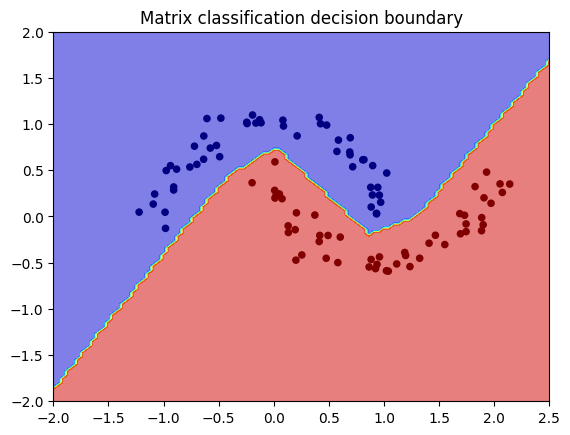

In [4]:
from matrixgrad import *
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

np.random.seed(12)  # 12th man, go Seahawks!

# Build the model
model = Sequential([Linear(2, 10), ReLU(), Linear(10, 1), Sigmoid()])
opt = Adam(model.parameters(), lr=.15, verbose=False)
loss_fn = binary_cross_entryopy_loss

# Train it
x, y = make_moons(n_samples=100, noise=0.1) # Two interlevered half circles
y = y.reshape ((100, 1, 1))                 # Make y an array of 1x1 arrays to match the output shape of the model
fit (model, x, y, loss_fn=loss_fn, optimizer=opt, epochs=100, batch_size=None, metrics=(accuracy,), verbose=True)

# Visualize the decision boundary
x1 = np.linspace(-2, 2.5, 100)
x2 = np.linspace(-2, 2, 100)
xx1, xx2 = np.meshgrid(x1, x2)
X = np.hstack((xx1.reshape(-1,1), xx2.reshape(-1,1)))
yhat = model(X).data
plt.contourf(x1, x2, np.round(yhat.reshape(100,100)), cmap='jet', alpha=.5)
plt.scatter(x[:,0], x[:,1], c=y, s=20, cmap='jet')
plt.title ("Matrix classification decision boundary")
plt.show()

PyTorch and TensorFLow versions of the above, for comparison...

Epoch 0: loss=0.7579, accuracy=29%
Epoch 1: loss=0.6900, accuracy=50%
Epoch 2: loss=0.6592, accuracy=60%
Epoch 3: loss=0.6251, accuracy=79%
Epoch 4: loss=0.5783, accuracy=84%
Epoch 5: loss=0.5201, accuracy=85%
Epoch 6: loss=0.4559, accuracy=82%
Epoch 7: loss=0.3968, accuracy=82%
Epoch 8: loss=0.3558, accuracy=82%
Epoch 9: loss=0.3364, accuracy=82%
Epoch 10: loss=0.3309, accuracy=82%
Epoch 11: loss=0.3279, accuracy=82%
Epoch 12: loss=0.3220, accuracy=82%
Epoch 13: loss=0.3128, accuracy=85%
Epoch 14: loss=0.3017, accuracy=85%
Epoch 15: loss=0.2902, accuracy=85%
Epoch 16: loss=0.2792, accuracy=83%
Epoch 17: loss=0.2682, accuracy=85%
Epoch 18: loss=0.2599, accuracy=88%
Epoch 19: loss=0.2569, accuracy=87%
Epoch 20: loss=0.2590, accuracy=86%
Epoch 21: loss=0.2606, accuracy=88%
Epoch 22: loss=0.2576, accuracy=88%
Epoch 23: loss=0.2513, accuracy=87%
Epoch 24: loss=0.2436, accuracy=88%
Epoch 25: loss=0.2349, accuracy=88%
Epoch 26: loss=0.2249, accuracy=88%
Epoch 27: loss=0.2160, accuracy=89%
Ep

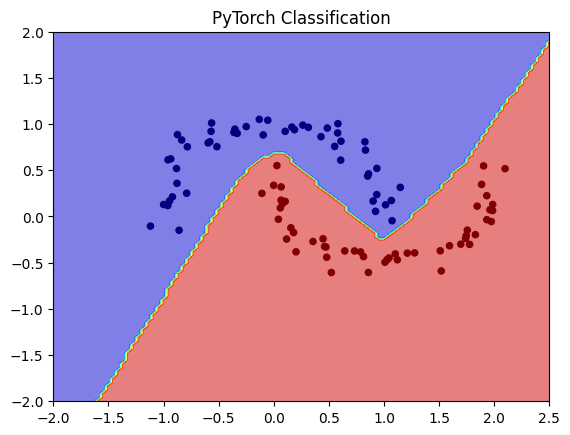

Epoch 1/200
4/4 [==============================] - 0s 7ms/step - loss: 0.6447 - accuracy: 0.6700
Epoch 2/200
4/4 [==============================] - 0s 4ms/step - loss: 0.3535 - accuracy: 0.8300
Epoch 3/200
4/4 [==============================] - 0s 4ms/step - loss: 0.2941 - accuracy: 0.8700
Epoch 4/200
4/4 [==============================] - 0s 3ms/step - loss: 0.2818 - accuracy: 0.9000
Epoch 5/200
4/4 [==============================] - 0s 3ms/step - loss: 0.2518 - accuracy: 0.8800
Epoch 6/200
4/4 [==============================] - 0s 3ms/step - loss: 0.2495 - accuracy: 0.8900
Epoch 7/200
4/4 [==============================] - 0s 3ms/step - loss: 0.2671 - accuracy: 0.8600
Epoch 8/200
4/4 [==============================] - 0s 3ms/step - loss: 0.2519 - accuracy: 0.9000
Epoch 9/200
4/4 [==============================] - 0s 3ms/step - loss: 0.2764 - accuracy: 0.8800
Epoch 10/200
4/4 [==============================] - 0s 4ms/step - loss: 0.2517 - accuracy: 0.8800
Epoch 11/200
4/4 [===========

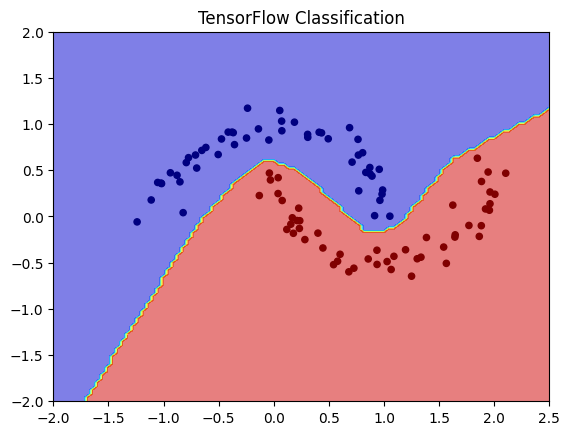

In [5]:
def torch_classification():
    """ Classification test """
    import matplotlib.pyplot as plt
    from sklearn.datasets import make_moons
    import torch

    np.random.seed(12)  # 12th man, go Seahawks!
    torch.manual_seed(12)

    # Build the model
    model = torch.nn.Sequential(
        torch.nn.Linear(2, 10),
        torch.nn.ReLU(),
        torch.nn.Linear(10, 1),
        torch.nn.Sigmoid())
    loss = torch.nn.functional.binary_cross_entropy
    opt = torch.optim.Adam(model.parameters(), lr=.1)

    # Train it
    x, y = make_moons(n_samples=100, noise=0.1)     # Two interlevered half circles
    y = y.reshape ((100, 1))                        # Make y an array of 1x1 arrays to match the output shape of the model
    y = torch.Tensor(y)
    for epoch in range(200):
        yhat = model(torch.Tensor(x))
        l = loss(yhat, torch.Tensor(y))
        opt.zero_grad()
        l.backward()
        opt.step()
        acc = (len(y) - torch.logical_xor(yhat > .5, y > .5).sum()) / len(y)
        print (f"Epoch {epoch}: loss={l.item():.4f}, accuracy={acc * 100:.0f}%")

    # visualize the decision boundary
    x1 = np.linspace(-2, 2.5, 100)
    x2 = np.linspace(-2, 2, 100)
    xx1, xx2 = np.meshgrid(x1, x2)
    X = np.hstack((xx1.reshape(-1,1), xx2.reshape(-1,1)))
    yhat = model(torch.Tensor(X)).detach().numpy()
    plt.contourf(x1, x2, np.round(yhat.reshape(100,100)), cmap='jet', alpha=.5)
    plt.scatter(x[:,0], x[:,1], c=y, s=20, cmap='jet')
    plt.title("PyTorch Classification")
    plt.show()

def tf_classification():
    import keras
    import  numpy as np
    import  matplotlib.pyplot as plt
    from    sklearn.datasets import make_moons

    # Build the model
    model = keras.models.Sequential([keras.layers.Dense(10, input_dim=2, activation="relu"),
                       keras.layers.Dense(1, activation="sigmoid")])
    loss = keras.losses.BinaryCrossentropy()
    opt = keras.optimizers.Adam(learning_rate=0.1)
    model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])

    # Train it
    x, y = make_moons(n_samples=100, noise=0.1)     # Two interlevered half circles
    y = y.reshape ((100, 1))                        # Make y an array of 1x1 arrays to match the output shape of the model
    model.fit(x, y, epochs=200)

    # Visualize the decision boundary
    x1 = np.linspace(-2, 2.5, 100)
    x2 = np.linspace(-2, 2, 100)
    xx1, xx2 = np.meshgrid(x1, x2)
    X = np.hstack((xx1.reshape(-1,1), xx2.reshape(-1,1)))
    yhat = model(X).numpy()
    plt.contourf(x1, x2, np.round(yhat.reshape(100,100)), cmap='jet', alpha=.5)
    plt.scatter(x[:,0], x[:,1], c=y, s=20, cmap='jet')
    plt.title("TensorFlow Classification")
    plt.show()

torch_classification()
tf_classification()
